In [1]:
import rom_inverse as ri
import torch
import matplotlib.pyplot as plt
import sklearn.gaussian_process.kernels as kernels
from poisson_fem import PoissonFEM
import ROM
import numpy as np
import scipy as sp
import petsc4py
import sys
petsc4py.init(sys.argv)
from petsc4py import PETSc

In [2]:
permeability_random_field = ri.DiscretizedRandomField(kernel=kernels.RBF(length_scale=[.01, .1]))

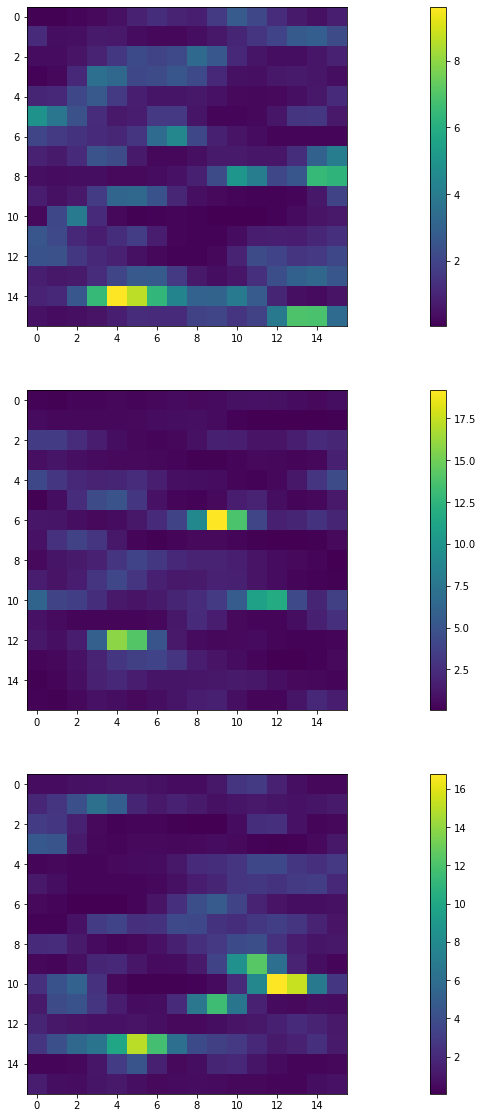

In [3]:
permeability_random_field.plot_realizations()

In [4]:
lin_dim_fom = 16                      # Linear number of rom elements
a = torch.tensor([-1, 0, 0])               # Boundary condition function coefficients


# Define mesh and boundary conditions
mesh = PoissonFEM.RectangularMesh(torch.ones(lin_dim_fom)/lin_dim_fom)
# mesh.plot()

def origin(x):
    return torch.abs(x[0]) < torch.finfo(torch.float32).eps and torch.abs(x[1]) < torch.finfo(torch.float32).eps

def ess_boundary_fun(x):
    return 0.0
mesh.set_essential_boundary(origin, ess_boundary_fun)

def domain_boundary(x):
    # unit square
    return torch.abs(x[0]) < torch.finfo(torch.float32).eps or torch.abs(x[1]) < torch.finfo(torch.float32).eps or \
            torch.abs(x[0]) > 1.0 - torch.finfo(torch.float32).eps or torch.abs(x[1]) > 1.0 - torch.finfo(torch.float32).eps
mesh.set_natural_boundary(domain_boundary)

def flux(x):
    q = np.array([a[0] + a[2]*x[1], a[1] + a[2]*x[0]])
    return q

In [5]:
#Specify right hand side and stiffness matrix
rhs = PoissonFEM.RightHandSide(mesh)
rhs.set_natural_rhs(mesh, flux)
K = PoissonFEM.StiffnessMatrix(mesh)
rhs.set_rhs_stencil(mesh, K)

Ke ==    (0, 0)	0.6666666
  (0, 17)	-0.16666664
  (0, 16)	-0.3333333
  (17, 0)	-0.16666664
  (17, 17)	0.6666666
  (17, 16)	-0.16666666
  (16, 0)	-0.3333333
  (16, 17)	-0.16666666
  (16, 16)	0.6666666
Ke ==    (0, 0)	0.6666666
  (0, 1)	-0.16666663
  (0, 18)	-0.33333337
  (0, 17)	-0.16666663
  (1, 0)	-0.16666663
  (1, 1)	0.6666666
  (1, 18)	-0.16666663
  (1, 17)	-0.33333337
  (18, 0)	-0.33333337
  (18, 1)	-0.16666663
  (18, 18)	0.6666666
  (18, 17)	-0.16666663
  (17, 0)	-0.16666663
  (17, 1)	-0.33333337
  (17, 18)	-0.16666663
  (17, 17)	0.6666666
Ke ==    (1, 1)	0.6666666
  (1, 2)	-0.16666663
  (1, 19)	-0.33333337
  (1, 18)	-0.16666663
  (2, 1)	-0.16666663
  (2, 2)	0.6666666
  (2, 19)	-0.16666663
  (2, 18)	-0.33333337
  (19, 1)	-0.33333337
  (19, 2)	-0.16666663
  (19, 19)	0.6666666
  (19, 18)	-0.16666663
  (18, 1)	-0.16666663
  (18, 2)	-0.33333337
  (18, 19)	-0.16666663
  (18, 18)	0.6666666
Ke ==    (2, 2)	0.6666666
  (2, 3)	-0.16666663
  (2, 20)	-0.33333337
  (2, 19)	-0.16666663
  (3, 2

Ke ==    (195, 195)	0.6666669
  (195, 196)	-0.16666687
  (195, 213)	-0.33333313
  (195, 212)	-0.16666687
  (196, 195)	-0.16666687
  (196, 196)	0.6666669
  (196, 213)	-0.16666687
  (196, 212)	-0.33333313
  (213, 195)	-0.33333313
  (213, 196)	-0.16666687
  (213, 213)	0.6666669
  (213, 212)	-0.16666687
  (212, 195)	-0.16666687
  (212, 196)	-0.33333313
  (212, 213)	-0.16666687
  (212, 212)	0.6666669
Ke ==    (196, 196)	0.6666669
  (196, 197)	-0.16666687
  (196, 214)	-0.33333313
  (196, 213)	-0.16666687
  (197, 196)	-0.16666687
  (197, 197)	0.6666669
  (197, 214)	-0.16666687
  (197, 213)	-0.33333313
  (214, 196)	-0.33333313
  (214, 197)	-0.16666687
  (214, 214)	0.6666669
  (214, 213)	-0.16666687
  (213, 196)	-0.16666687
  (213, 197)	-0.33333313
  (213, 214)	-0.16666687
  (213, 213)	0.6666669
Ke ==    (197, 197)	0.6666669
  (197, 198)	-0.16666687
  (197, 215)	-0.33333313
  (197, 214)	-0.16666687
  (198, 197)	-0.16666687
  (198, 198)	0.6666669
  (198, 215)	-0.16666687
  (198, 214)	-0.33333313

In [6]:
# define fom
fom = ROM.ROM(mesh, K, rhs, lin_dim_fom**2)
# Change for non unit square domains!!
xx, yy = torch.meshgrid((torch.linspace(0, 1, lin_dim_fom), torch.linspace(0, 1, lin_dim_fom)))
X = torch.cat((xx.flatten().unsqueeze(1), yy.flatten().unsqueeze(1)), 1)
fom.mesh.get_interpolation_matrix(X)

In [7]:
fom_autograd = fom.get_autograd_fun()

In [8]:
lmbda = permeability_random_field.sample(n_samples=3)
lmbda = torch.ones(lin_dim_fom**2, 3)

forward time ==  0.0006306171417236328


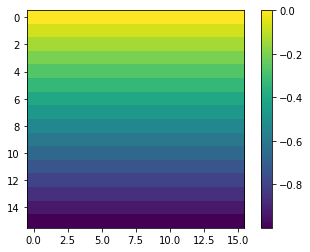

In [9]:
img = plt.imshow(fom_autograd(lmbda[:, 0]).view(lin_dim_fom, lin_dim_fom))
plt.colorbar(img)

In [10]:
lmbda = torch.ones(lin_dim_fom**2, requires_grad=True)
x = fom_autograd(lmbda)

forward time ==  0.0007171630859375


In [11]:
loss = torch.norm(x)

In [12]:
loss

tensor(9.3894, grad_fn=<NormBackward0>)

In [13]:
loss.backward()

backward time ==  0.0014488697052001953


In [14]:
lmbda.grad

tensor([-0.6598, -0.3107, -0.2053, -0.1525, -0.1212, -0.1002, -0.0849, -0.0729,
        -0.0628, -0.0540, -0.0460, -0.0384, -0.0309, -0.0236, -0.0162, -0.0090,
        -0.0682, -0.2077, -0.1663, -0.1348, -0.1118, -0.0947, -0.0813, -0.0704,
        -0.0611, -0.0528, -0.0450, -0.0376, -0.0304, -0.0231, -0.0156, -0.0075,
        -0.0400, -0.0942, -0.1160, -0.1081, -0.0964, -0.0852, -0.0751, -0.0662,
        -0.0581, -0.0506, -0.0434, -0.0364, -0.0294, -0.0224, -0.0150, -0.0074,
        -0.0210, -0.0567, -0.0765, -0.0823, -0.0796, -0.0739, -0.0674, -0.0607,
        -0.0542, -0.0477, -0.0413, -0.0348, -0.0282, -0.0215, -0.0145, -0.0072,
        -0.0135, -0.0374, -0.0539, -0.0623, -0.0645, -0.0629, -0.0594, -0.0548,
        -0.0497, -0.0444, -0.0388, -0.0330, -0.0269, -0.0206, -0.0139, -0.0070,
        -0.0095, -0.0267, -0.0399, -0.0484, -0.0524, -0.0532, -0.0518, -0.0490,
        -0.0453, -0.0409, -0.0361, -0.0310, -0.0255, -0.0196, -0.0134, -0.0068,
        -0.0071, -0.0202, -0.0310, -0.03

In [15]:
def lossfun(x):
    return torch.norm(fom_autograd(x)) 

In [16]:
# from torch.autograd import gradcheck
# lmbda = torch.randn(lin_dim_fom**2, dtype=torch.double, requires_grad=True)
# test = gradcheck(lossfun, lmbda, eps=1e-3, atol=1e-4)
# print(test)

In [17]:
x = sp.sparse.csr_matrix(np.random.rand(3,5))
print(x.todense())

[[0.81226288 0.22865596 0.88778557 0.8760744  0.15302029]
 [0.25474502 0.07761703 0.74982738 0.15101768 0.5001633 ]
 [0.20992702 0.67078027 0.95512119 0.96551186 0.19386945]]


In [18]:
print(x.reshape(15, 1))

  (0, 0)	0.8122628753947225
  (1, 0)	0.2286559562498519
  (2, 0)	0.8877855730948472
  (3, 0)	0.8760743959765794
  (4, 0)	0.15302028679700763
  (5, 0)	0.25474502006058375
  (6, 0)	0.07761703000789544
  (7, 0)	0.7498273758608064
  (8, 0)	0.15101767751072304
  (9, 0)	0.5001633033883901
  (10, 0)	0.2099270237228047
  (11, 0)	0.6707802741544027
  (12, 0)	0.9551211938052533
  (13, 0)	0.9655118616034917
  (14, 0)	0.19386944564774766


In [19]:
print(x.T.reshape(15, 1))

  (0, 0)	0.8122628753947225
  (3, 0)	0.2286559562498519
  (6, 0)	0.8877855730948472
  (9, 0)	0.8760743959765794
  (12, 0)	0.15302028679700763
  (1, 0)	0.25474502006058375
  (4, 0)	0.07761703000789544
  (7, 0)	0.7498273758608064
  (10, 0)	0.15101767751072304
  (13, 0)	0.5001633033883901
  (2, 0)	0.2099270237228047
  (5, 0)	0.6707802741544027
  (8, 0)	0.9551211938052533
  (11, 0)	0.9655118616034917
  (14, 0)	0.19386944564774766


In [20]:
x.T.todense().reshape(15, 1)

matrix([[0.81226288],
        [0.25474502],
        [0.20992702],
        [0.22865596],
        [0.07761703],
        [0.67078027],
        [0.88778557],
        [0.74982738],
        [0.95512119],
        [0.8760744 ],
        [0.15101768],
        [0.96551186],
        [0.15302029],
        [0.5001633 ],
        [0.19386945]])

In [21]:
x = sp.sparse.coo_matrix((5, 3))

In [22]:
a = np.zeros(5)

In [23]:
a[3] = 1.23

In [24]:
mask = a == 0

In [25]:
a[mask]

array([0., 0., 0., 0.])